# Análisis de certificados en Catastro

**Autor:** Roberto Muñoz <br />
**E-mail:** <rmunoz@metricarts.com> <br />
**Github:** <https://github.com/rpmunoz> <br />

La división de gobierno digital necesita crear un método que identifique y clasifique de manera automática los trámites que están disponibles en la página web www.chileatiende.cl

En este notebook veremos como usar pandas para cargas archivos excel e identificar los trámites que son del tipo certificados


In [1]:
import os
import pandas as pd
import numpy as np
import json
from itertools import groupby

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

# 1. Cargamos en memoria el archivo de Catastro

In [3]:
catastro_file="data/Catastro 23082018 V4.xlsx"
catastro_df=pd.read_excel(catastro_file)
catastro_df.head()

,Origen de los datos,Ministerio,Subsecretaría,Institución,Última actualización,ID trámite,Tipo de Servicio del Estado,Tipo de Producto,Producto,Nombre del trámite,...,Postulable,Este trámite es estacional,Fecha inicio,Fecha término,¿Este trámite utiliza un mecanismo de autenticación?,¿El Trámite considera pago?,Solicita documentos notariados,Requisitos,Registro social de hogares,Marco legal
0,Catastro de trámites 2017,Ministerio de Hacienda,Subsecretaría de Hacienda,Unidad de Análisis Financiero,Ejercicio Junio 2018,SINID169,TRÁMITE,REGISTRO / INSCRIPCIÓN,Registro de Entidades Reportantes,Inscripción en el Registro de Entidades Repor...,...,NaN,No,PENDIENTE,PENDIENTE,No,No,NO,completar y enviar formulario online,No,artículo 40 de la Ley N° 19.913
1,Catastro de trámites 2017,Ministerio de Hacienda,Subsecretaría de Hacienda,Unidad de Análisis Financiero,Ejercicio Junio 2018,SINID169,TRÁMITE,REGISTRO / INSCRIPCIÓN,Registro de Entidades Reportantes,Inscripción en el Registro de Entidades Repor...,...,NaN,No,PENDIENTE,PENDIENTE,No,No,NO,completar y enviar formulario online,No,artículo 40 de la Ley N° 19.913
2,Catastro de trámites 2017,Ministerio de Hacienda,Subsecretaría de Hacienda,Unidad de Análisis Financiero,Ejercicio Junio 2018,SINID170,TRÁMITE,ATENCIÓN CIUDADANA,Atención ciudadana,Consultas ciudadanas,...,NaN,No,PENDIENTE,PENDIENTE,No,No,NO,ninguno,No,No encontrado
3,Catastro de trámites 2017,Ministerio de Hacienda,Subsecretaría de Hacienda,Unidad de Análisis Financiero,Ejercicio Junio 2018,SINID173,TRÁMITE,ATENCIÓN CIUDADANA,Acceso a la Información Pública,Solicitud de Acceso a la Información Pública (...,...,NaN,No,PENDIENTE,PENDIENTE,No,No,NO,ninguno,No,Ley 20.285
4,Catastro de trámites 2017,Ministerio de Hacienda,Subsecretaría de Hacienda,Unidad de Análisis Financiero,Ejercicio Junio 2018,SINID1785,TRÁMITE,ATENCIÓN CIUDADANA,Audencia Pública,Solicitud de Audiencia (Ley 20.730),...,NaN,No,PENDIENTE,PENDIENTE,"Si, con Claveúnica",No,NO,ninguno,No,Ley 20.730


In [4]:
catastro_df.columns

Index(['Origen de los datos', 'Ministerio', 'Subsecretaría', 'Institución',
       'Última actualización', 'ID trámite', 'Tipo de Servicio del Estado',
       'Tipo de Producto', 'Producto', 'Nombre del trámite',
       'Descripción del producto', 'Definición del trámite',
       'URL del trámite (web institucional)',
       'URL del trámite en ChileAtiende', 'Nivel de Digitalización', 'Canal',
       'Categoría Tipo de usuario persona natural - jurídica',
       '¿Emprendedores o MiPyme?', 'Actividad económica',
       'Categoría Habilitante', 'Categoría Género', 'Categoría Edad',
       'Categoría Actividad', 'Categoría Discapacidad',
       'Categoría Calidad Indígena', 'Categoría Nacionalidad', 'Postulable',
       'Este trámite es estacional', 'Fecha inicio', 'Fecha término',
       '¿Este trámite utiliza un mecanismo de autenticación?',
       '¿El Trámite considera pago?', 'Solicita documentos notariados',
       'Requisitos', 'Registro social de hogares', 'Marco legal'],
      

In [5]:
len(catastro_df)

4373

In [6]:
len(catastro_df['ID trámite'].unique())

3906

In [7]:
len(catastro_df['Nombre del trámite'].unique())

3135

In [8]:
with pd.option_context('display.max_colwidth', 300):
    print(catastro_df.loc[catastro_df['Nombre del trámite'].str.contains('nacimiento'), ['ID trámite','Nombre del trámite']])

     ID trámite  \
1848       3394   
1901       9380   
1904      13828   
1905      13834   
2125       2386   
2729      26577   

                                                          Nombre del trámite  
1848                                               Inscripción de nacimiento  
1901                             Certificado de nacimiento para todo trámite  
1904                      Certificado de nacimiento para asignación familiar  
1905                                Certificado de nacimiento para matrícula  
2125      Solicitar certificado de nacimiento para chilenos en el extranjero  
2729  Subsidio de nacimiento de la ex Caja de Empleados del Banco del Estado  


# 2. Extraemos las columnas de interes

In [9]:
columns=['ID trámite','Nombre del trámite','Requisitos']

data_df = catastro_df[columns].copy()
data_df.rename(index=int, columns={'ID trámite': 'id_tramite', 'Nombre del trámite': 'nombre_tramite', 'Requisitos': 'requisitos'}, inplace=True)
data_df.head()

,id_tramite,nombre_tramite,requisitos
0,SINID169,Inscripción en el Registro de Entidades Repor...,completar y enviar formulario online
1,SINID169,Inscripción en el Registro de Entidades Repor...,completar y enviar formulario online
2,SINID170,Consultas ciudadanas,ninguno
3,SINID173,Solicitud de Acceso a la Información Pública (...,ninguno
4,SINID1785,Solicitud de Audiencia (Ley 20.730),ninguno


Convertimos el campo ID trámite a un tipo de datos string

In [10]:
data_df['id_tramite'] = data_df['id_tramite'].astype(str)

In [11]:
data_df['LEN_id_tramite'] = data_df['id_tramite'].str.len()

Ordenamos por el largo del campo id_tramite para identificar posibles errores en el tipeo

In [12]:
data_df.sort_values('LEN_id_tramite').head()

,id_tramite,nombre_tramite,requisitos,LEN_id_tramite
2200,1,Solicitud de certificación de vehículos a gas,"anexos i, ii, iii y iv del oficio circular n°1...",1
2201,7,Solicitud de homologación de vehículos liviano...,ninguno,1
2197,10,Solicitud de certificación de convertidores ca...,"anexos 1 y 2 del oficio circular n°110/2000, d...",2
1689,70,Certificado de Valor,descripción de la mercancía - facturas de compra.,2
1690,52,Solicitar Permiso para la ingreso temporal de ...,documento de identificación del conductor (céd...,2


Indentificamos los registros con ID trámite NULL

In [13]:
data_df[data_df['id_tramite'].isnull()]

,id_tramite,nombre_tramite,requisitos,LEN_id_tramite


Indentificamos los registros con ID trámite = NUEVO

In [14]:
data_df[data_df['id_tramite'].str.contains('NUEVO')].sort_values('id_tramite')

,id_tramite,nombre_tramite,requisitos,LEN_id_tramite
2948,NUEVO001,Proyectos de Gestión para la Innovación en Emp...,acreditar que cuenta con personalidad jurídica...,8
2949,NUEVO002,Proyectos de Emprendimiento Innovador Jóvenes ...,acreditar que cuenta con personalidad jurídica...,8
2955,NUEVO003,Postular a ÑAM Mercado 2018,acreditar que cuenta con personalidad jurídica...,8
2961,NUEVO004,"Acceder Oficina de informaciones, reclamos y s...",completar formulario,8
2962,NUEVO005,Registro Especial de Proveedores,solicitud de inscripción en el registro especi...,8
3083,NUEVO006,Solicitud de aprobación de planos de instalaci...,los establecidos en la resolución dgtm y mm or...,8
3084,NUEVO007,Solicitud aprobación análisis de estabilidad,"presentar el análisis de estabilidad, el que d...",8
3085,NUEVO008,Asignacion de distintivo de llamada para una N...,presentar la solicitud (carta) al sr. capitán ...,8
3086,NUEVO009,Solicitud de certificado de dotación mínima se...,presentar solicitud formal a la gobernación ma...,8
3087,NUEVO010,Solicitud certificado de arqueo,"planos de líneas, arreglo general “visado” por...",8


Copiamos el index en un campo llamado row_excel y sumamos el valor 2

## 3. Limpiamos y parseamos el campo requisitos

In [15]:
import re
import unicodedata

def standardize_string(row):
    result = row.lower()
    result = unicodedata.normalize('NFD', result)
    result = result.encode('ascii', 'ignore')
    result = result.decode("utf-8")
    return result

def parse_string(row):
    #result = re.split('-|\n', row)
    #result = list(map(lambda x: re.sub('\n$', '', x), result))
    result = re.split('-', row)
    result = list(map(lambda x: x.replace('\n', ' '), result))
    result = list(map(lambda x: re.sub(' +', ' ', x), result))
    result = list(map(str.strip, result))
    result = list(filter(None, result))
    return result

def parse_string_new_line(row):
    result = re.split('\n', row)
    result = list(map(str.strip, result))
    result = list(filter(None, result))
    return result

def remove_numbering(row):
    result = list(map(lambda x: re.sub('^[0-9]+\.', '', x), row))
    result = list(map(str.strip, result))
    return result
    
def remove_stopwords(row):
    stop_spanish = stopwords.words('spanish')
    
    result = ' '.join([word for word in row])
    result = ' '.join([word for word in result.split() if word not in stop_spanish])
    return result

def get_max_length(row):
    result=[]
    for word in row:
        result.append(len(word))
    result = max(result)
    return result

def get_number_new_line(row):
    result=0
    for word in row:
        result += len(re.findall("\n", word))
    return result

def get_hyphens_numbers(row):
    result=re.findall("\w+.{,2}(?:[0-9]+|[a-zA-Z]+)-(?:[0-9]+).{,2}\w+", row)
    return result

def get_hyphens(row):
    result=re.findall("\w+.{,2}\w+-\w+.{,2}\w+", row)
    return result

### Identificamos las palabras que estan unidas por guiones y reemplazamos - por _ para estos pocos casos

In [16]:
data_df['requisitos_clean'] = data_df['requisitos'].apply(standardize_string)

In [17]:
#temp_df=data_df['requisitos_clean'].apply(get_hyphens)
#temp_df=temp_df[temp_df.str.len() > 0]
#for idx, row in temp_df.iteritems():
#    print(idx, row)

In [18]:
hyphens_list1=['te-4','formulario sl-1','datum wgs-84','900.183-2','v-5','901265-6','fpi-50',
               'o-71/026','o-73/002','certificado f-30','mp3-256 kbps','formulario 30-1','gr -g-03','weg-84',
               'w3-article-4833', 'articles-4833_recurso']

In [19]:
hyphens_list2=['e-declarador','chile-espana','ipso-jure','visa-de-residencia',
               'solicitud-reconcideracio','81n-visa','permanencia-definitiva','directores-accionistas',
               'teorico-practico','on-line','re-exportacion','formulario-tipo','sub-rol','compra-venta',
               'empresa-individual','ex-cora','poblacion-objetivo','carta-compromiso','ips-chileatiende',
               'im-ponentes','anos-calendario','teorica-metodologica','tele-vigilancia','mai-ges','in-situ',
               'y de-los','urbano-arquitectonico','documentacion- del ano en curso-que','blu-ray','bio-bibliografica',
               'post-doctorados','cd-rom','ingreso-sai-v2','declara-cion','en-tidad','anexo n 8-a','imp-mp3',
               're-circulacion','inn-sernapesca','co-responsables']

In [20]:
hyphens_list = hyphens_list1 + hyphens_list2
hyphens_dict = {x: x.replace('-', '_') for x in hyphens_list}

In [21]:
for key, val in hyphens_dict.items():
    data_df['requisitos_clean'] = data_df['requisitos_clean'].str.replace(key, val, regex=False)

### Hacemos un parsing del campo requisitos_clean

In [22]:
data_df['LEN_requisitos_clean'] = data_df['requisitos_clean'].str.len()

In [23]:
data_df['N_NEW_LINE_requisitos_clean'] = data_df['requisitos_clean'].apply(get_number_new_line)

In [24]:
data_df['requisitos_parse'] = data_df['requisitos_clean'].apply(parse_string)

In [25]:
data_df['requisitos_parse'] = data_df['requisitos_parse'].apply(remove_numbering)

In [26]:
data_df['MAX_LEN_requisitos_parse'] = data_df['requisitos_parse'].apply(get_max_length)

In [27]:
data_df['N_requisitos_parse'] = data_df['requisitos_parse'].str.len()

In [28]:
data_df.head()

,id_tramite,nombre_tramite,requisitos,LEN_id_tramite,requisitos_clean,LEN_requisitos_clean,N_NEW_LINE_requisitos_clean,requisitos_parse,MAX_LEN_requisitos_parse,N_requisitos_parse
0,SINID169,Inscripción en el Registro de Entidades Repor...,completar y enviar formulario online,8,completar y enviar formulario online,36,0,[completar y enviar formulario online],36,1
1,SINID169,Inscripción en el Registro de Entidades Repor...,completar y enviar formulario online,8,completar y enviar formulario online,36,0,[completar y enviar formulario online],36,1
2,SINID170,Consultas ciudadanas,ninguno,8,ninguno,7,0,[ninguno],7,1
3,SINID173,Solicitud de Acceso a la Información Pública (...,ninguno,8,ninguno,7,0,[ninguno],7,1
4,SINID1785,Solicitud de Audiencia (Ley 20.730),ninguno,9,ninguno,7,0,[ninguno],7,1


In [29]:
data_df.loc[data_df['id_tramite']=='SINID778']

,id_tramite,nombre_tramite,requisitos,LEN_id_tramite,requisitos_clean,LEN_requisitos_clean,N_NEW_LINE_requisitos_clean,requisitos_parse,MAX_LEN_requisitos_parse,N_requisitos_parse
21,SINID778,Fiscalizacion de normas de emisión,cédula de identidad\n-documento de designacion...,8,cedula de identidad\n-documento de designacion...,183,2,"[cedula de identidad, documento de designacion...",89,3


### Buscamos registros que contengan un gran numero de saltos de linea

In [30]:
temp_df = data_df.sort_values('N_requisitos_parse', ascending=True)
temp_df['ratio_N_NEW_LINE'] = temp_df['N_NEW_LINE_requisitos_clean']/temp_df['N_requisitos_parse']

columns=['id_tramite','MAX_LEN_requisitos_parse','N_requisitos_parse','N_NEW_LINE_requisitos_clean','ratio_N_NEW_LINE']
temp_df = temp_df[temp_df['N_requisitos_parse']<=10][columns]
temp_df = temp_df.sort_values('ratio_N_NEW_LINE', ascending=False).head(30)
temp_df

,id_tramite,MAX_LEN_requisitos_parse,N_requisitos_parse,N_NEW_LINE_requisitos_clean,ratio_N_NEW_LINE
3782,SINID1536,768,2,6,3.000000
4281,NUEVO170,62,8,21,2.625000
3788,SINID1540,548,10,25,2.500000
4227,NUEVO118,958,7,16,2.285714
2896,SINID370-5,559,4,9,2.250000
1767,4171,404,1,2,2.000000
3777,SINID1567,353,3,6,2.000000
3784,529,266,5,10,2.000000
3813,SINID1550,1888,9,17,1.888889
1868,3337,721,10,18,1.800000


In [31]:
data_df.loc[2896,'requisitos_parse']

['formulario de postulacion.',
 'b) planilla presupuesto.',
 'c) cotizaciones , dos por cada producto solicitado, que avalen la solicitud financiera y presupuestaria del proyecto. para honorarios solo 1 cotizacion que senale nombre de la persona, rut, direccion, telefonos, monto debe venir firmada por el profesional. tratandose de gastos de cualquier naturaleza, que correspondan a proveedores unicos, no regira la limitacion de entrega de (2) dos cotizaciones, dicha condicion debera ser justificada por la entidad participante al momento de la postulacion mediante un certificado emitido por el proveedor respectivo."',
 'd) indicacion del n de cuenta bancaria a la cual se deben girar los fondos si el proyecto es seleccionado.']

In [32]:
if not os.path.exists('results'):
    os.mkdir('results')

output_file='results/catastro_tramites - revisar_saltos_linea_requisitos.xlsx'

writer = pd.ExcelWriter(output_file, engine='xlsxwriter')
temp_df.to_excel(writer, sheet_name='Sheet1', index=False)

workbook  = writer.book
worksheet = writer.sheets['Sheet1']

worksheet.set_column('A:E', 20)

end_row = len(temp_df.index)
end_column = len(temp_df.columns)-1
header = [{'header': word} for word in temp_df.columns.tolist()]

worksheet.add_table(0, 0, end_row, end_column, {'header_row': True, 'columns': header})
writer.save()

### Ordenamos los registros por el largo del campo requisitos_clean - LEN_requisitos_clean

In [33]:
data_df.sort_values('LEN_requisitos_clean', ascending=True).head()

,id_tramite,nombre_tramite,requisitos,LEN_id_tramite,requisitos_clean,LEN_requisitos_clean,N_NEW_LINE_requisitos_clean,requisitos_parse,MAX_LEN_requisitos_parse,N_requisitos_parse
274,SINID1475,solicitud de Visa de residencia temporaria,N,9,n,1,0,[n],1,1
2601,SINID1652,Solicitud de Acceso a la Información Pública (...,rut,9,rut,3,0,[rut],3,1
2042,SINID1690,Solicitud de Acceso a la Información Pública (...,ninguno,9,ninguno,7,0,[ninguno],7,1
3254,SINID1616,"Acceder a la Oficina de Información, Reclamos ...",ninguno,9,ninguno,7,0,[ninguno],7,1
3255,SINID494,Solicitud de Acceso a la Información Pública (...,ninguno,8,ninguno,7,0,[ninguno],7,1


In [34]:
data_df.sort_values('LEN_requisitos_clean', ascending=False).head()

,id_tramite,nombre_tramite,requisitos,LEN_id_tramite,requisitos_clean,LEN_requisitos_clean,N_NEW_LINE_requisitos_clean,requisitos_parse,MAX_LEN_requisitos_parse,N_requisitos_parse
3809,SINID1562,Postular al Programa de apoyo al patrimonio au...,modalidad de difusión en medios digitales : 1....,9,modalidad de difusion en medios digitales : 1....,14438,140,[modalidad de difusion en medios digitales : 1...,1397,24
4174,NUEVO065,Acceder a Línea de Formación,(Modalidad Becas Magister): Documento oficial ...,8,(modalidad becas magister): documento oficial ...,14019,0,[(modalidad becas magister): documento oficial...,1336,21
3808,SINID1532,Apoyo a la distribución de cine nacional,modalidad de apoyo a la distribución de cine n...,9,modalidad de apoyo a la distribucion de cine n...,11317,91,[modalidad de apoyo a la distribucion de cine ...,1371,19
4172,NUEVO063,Acceder a Línea de Fomento a la Industria,(Modalidad Salas de Concierto y Estudios de Gr...,8,(modalidad salas de concierto y estudios de gr...,10741,2,[(modalidad salas de concierto y estudios de g...,1333,17
2892,SINID370-6,Postulación a Fondos Concursables FNDR,cultura - 1. carta de solicitud de recursos fi...,10,cultura - 1. carta de solicitud de recursos fi...,10625,154,"[cultura, carta de solicitud de recursos firma...",701,46


Revisamos el registro 4173, el cual tiene un largo de 10741 caracteres el campo requisitos y solo fue parseado en 17 elementos

In [35]:
data_df.loc[4173, 'requisitos_parse']

['(modalidad produccion de registro fonografico de musica nacional de raiz folklorica y de pueblos originarios): demo y/o partitura: presentar grabacion de prueba de, al menos, tres temas del disco postulado a modo de avance de la obra, en formato mp3., mp4., .mov, .avi, .mpg; cd (este ultimo solo en el caso que la postulacion sea en soporte papel).',
 '(modalidad produccion de registro fonografico de musica nacional de raiz folklorica y de pueblos originarios)autorizacion o cesion de derechos de autor (si corresponde): si el proyecto comprende el uso de obras protegidas por el derecho de autor cuyos titulares son personas, naturales o juridicas, distintas del postulante, debera adjuntarse una autorizacion o cesion expresa del titular de los derechos de autor sobre la obra. si se adjunta una autorizacion, esta debera contener, al menos, la identidad de quien otorga la autorizacion y de quien la recibe, asi como la forma de uso de la obra protegida por el derecho de autor cuya autorizac

### Ordenamos los registros por el numero de elementos del campo requisitos_parse - N_requisitos_parse

In [36]:
data_df.sort_values('N_requisitos_parse', ascending=True).head()

,id_tramite,nombre_tramite,requisitos,LEN_id_tramite,requisitos_clean,LEN_requisitos_clean,N_NEW_LINE_requisitos_clean,requisitos_parse,MAX_LEN_requisitos_parse,N_requisitos_parse
0,SINID169,Inscripción en el Registro de Entidades Repor...,completar y enviar formulario online,8,completar y enviar formulario online,36,0,[completar y enviar formulario online],36,1
2165,SINID1680,"Acceder a la Oficina de informaciones, reclamo...",ninguno,9,ninguno,7,0,[ninguno],7,1
2166,SINID1681,Solicitud de Audiencia (Ley 20.730),ninguno,9,ninguno,7,0,[ninguno],7,1
2167,SINID1682,Solicitud de Acceso a la Información Pública (...,ninguno,9,ninguno,7,0,[ninguno],7,1
2171,2350,Reclamo por problemas de atención en el sistem...,se pueden adjuntar todos los antecedentes que ...,4,se pueden adjuntar todos los antecedentes que ...,121,0,[se pueden adjuntar todos los antecedentes que...,121,1


In [37]:
data_df.sort_values('N_requisitos_parse', ascending=False).head()

,id_tramite,nombre_tramite,requisitos,LEN_id_tramite,requisitos_clean,LEN_requisitos_clean,N_NEW_LINE_requisitos_clean,requisitos_parse,MAX_LEN_requisitos_parse,N_requisitos_parse
2910,SINID370-4,Postulación a Fondos Concursables FNDR,- fondo cultura\nfotocopia legible del rut de ...,10,- fondo cultura\nfotocopia legible del rut de ...,8997,13,[fondo cultura fotocopia legible del rut de la...,440,54
3597,715,Inscripción en el Registro de consultores,personas naturales: - copia legalizada ante no...,3,personas naturales: - copia legalizada ante no...,10297,6,"[personas naturales:, copia legalizada ante no...",877,53
2880,SINID370-8,Postulación a Fondos Concursables FNDR,"cultura a) un sobre cerrado, que contenga todo...",10,"cultura a) un sobre cerrado, que contenga todo...",8387,61,"[cultura a) un sobre cerrado, que contenga tod...",1427,48
2892,SINID370-6,Postulación a Fondos Concursables FNDR,cultura - 1. carta de solicitud de recursos fi...,10,cultura - 1. carta de solicitud de recursos fi...,10625,154,"[cultura, carta de solicitud de recursos firma...",701,46
356,5110,Solicitud de inscripción en el Registro Nacion...,solicitud con los datos requeridos - fotocopia...,4,solicitud con los datos requeridos - fotocopia...,5548,2,"[solicitud con los datos requeridos, fotocopia...",331,39


In [38]:
data_df.sort_values('N_requisitos_parse', ascending=False).head(100).to_excel('results/catastro_tramites - N_requisitos_parse.xlsx', 
            startcol=0,
            startrow=0)

Revisamos el registro con indice 2893, que contiene 48 parrafos y el parrafo mas largo tiene 1427 caracteres

In [39]:
data_df.loc[2893, 'requisitos_clean']

'cultura- \n- 1.carta de solicitud de recursos firmada por alcalde o alcaldesa,gobernador y/o representante de la institucion publica, dirigida al senor intendente\nregional, senalando nombre de iniciativa y monto requerido. (anexo formulario n1). \n- 2. formulario de postulacion en formato anillado establecido y actualizado al\nano de postulacion.\n - 3. declaracion jurada notarial que indique que la iniciativa tiene exclusividad\nde postulacion al fondo fndr de cultura. ademas la declaracion notarial debe\nindicar la gratuidad de la totalidad de las actividades enmarcadas en el proyecto.\n(anexo formulario n 2).\n- 4. declaracion jurada simple que indique si tienen o no, entre sus directores\ny /o administradores a personas que posean la calidad de consejeros regionales\no funcionarios del gobierno regional que presten servicios como planta, contrata\nu honorarios en el mismo. (anexo formulario n 3)\n- 5. carta de compromiso o certificado de aportes propios o de terceros,\nindicando 

In [40]:
data_df.loc[2893, 'requisitos_parse']

['cultura',
 'carta de solicitud de recursos firmada por alcalde o alcaldesa,gobernador y/o representante de la institucion publica, dirigida al senor intendente regional, senalando nombre de iniciativa y monto requerido. (anexo formulario n1).',
 'formulario de postulacion en formato anillado establecido y actualizado al ano de postulacion.',
 'declaracion jurada notarial que indique que la iniciativa tiene exclusividad de postulacion al fondo fndr de cultura. ademas la declaracion notarial debe indicar la gratuidad de la totalidad de las actividades enmarcadas en el proyecto. (anexo formulario n 2).',
 'declaracion jurada simple que indique si tienen o no, entre sus directores y /o administradores a personas que posean la calidad de consejeros regionales o funcionarios del gobierno regional que presten servicios como planta, contrata u honorarios en el mismo. (anexo formulario n 3)',
 'carta de compromiso o certificado de aportes propios o de terceros, indicando detalladamente por it

### Ordenamos los registros por el maximo largo de los elementos del campo requisitos_parse - MAX_LEN_requisitos_parse

In [41]:
data_df.sort_values('MAX_LEN_requisitos_parse', ascending=True).head()

,id_tramite,nombre_tramite,requisitos,LEN_id_tramite,requisitos_clean,LEN_requisitos_clean,N_NEW_LINE_requisitos_clean,requisitos_parse,MAX_LEN_requisitos_parse,N_requisitos_parse
274,SINID1475,solicitud de Visa de residencia temporaria,N,9,n,1,0,[n],1,1
2601,SINID1652,Solicitud de Acceso a la Información Pública (...,rut,9,rut,3,0,[rut],3,1
1627,SINID1701,Solicitud de Audiencia (Ley 20.730),ninguno,9,ninguno,7,0,[ninguno],7,1
742,16617,Obtención de Informe de Factibilidad Económica...,ninguno,5,ninguno,7,0,[ninguno],7,1
744,SINID1078,Acceder al Sistema Integral de Información y A...,ninguno,9,ninguno,7,0,[ninguno],7,1


In [42]:
data_df.sort_values('MAX_LEN_requisitos_parse', ascending=False).head()

,id_tramite,nombre_tramite,requisitos,LEN_id_tramite,requisitos_clean,LEN_requisitos_clean,N_NEW_LINE_requisitos_clean,requisitos_parse,MAX_LEN_requisitos_parse,N_requisitos_parse
4287,NUEVO175,MODIFICACIÓN SUSTANCIAL DE CONCESIÓN MARÍTIMA ...,Formulario de solicitud dirigido al Ministerio...,8,formulario de solicitud dirigido al ministerio...,9177,45,[formulario de solicitud dirigido al ministeri...,3115,14
4291,NUEVO179,OTORGAMIENTO DE CONCESIÓN MARÍTIMA MAYOR.,Formulario de solicitud dirigido al Ministerio...,8,formulario de solicitud dirigido al ministerio...,9184,45,[formulario de solicitud dirigido al ministeri...,3115,14
4292,NUEVO180,OTORGAMIENTO DE CONCESIÓN MARÍTIMA MENOR.,Formulario de solicitud dirigido al Ministerio...,8,formulario de solicitud dirigido al ministerio...,9446,12,[formulario de solicitud dirigido al ministeri...,2412,13
4293,NUEVO181,OTORGAMIENTO DE DESTINACIÓN MARÍTIMA,Formulario de solicitud dirigido al Ministerio...,8,formulario de solicitud dirigido al ministerio...,7391,9,[formulario de solicitud dirigido al ministeri...,2117,11
4290,NUEVO178,MODIFICACIÓN SUSTANCIAL DE CONCESIÓN MARÍTIMA ...,Formulario de solicitud dirigido al Ministerio...,8,formulario de solicitud dirigido al ministerio...,9528,13,[formulario de solicitud dirigido al ministeri...,1966,17


In [43]:
data_df.sort_values('MAX_LEN_requisitos_parse', ascending=False).head(100).to_excel('results/catastro_tramites - MAX_LEN_requisitos_parse.xlsx', 
            startcol=0, 
            startrow=0)

# 4. Expandimos el campo requisitos_parse

In [44]:
data_df.head(10)

,id_tramite,nombre_tramite,requisitos,LEN_id_tramite,requisitos_clean,LEN_requisitos_clean,N_NEW_LINE_requisitos_clean,requisitos_parse,MAX_LEN_requisitos_parse,N_requisitos_parse
0,SINID169,Inscripción en el Registro de Entidades Repor...,completar y enviar formulario online,8,completar y enviar formulario online,36,0,[completar y enviar formulario online],36,1
1,SINID169,Inscripción en el Registro de Entidades Repor...,completar y enviar formulario online,8,completar y enviar formulario online,36,0,[completar y enviar formulario online],36,1
2,SINID170,Consultas ciudadanas,ninguno,8,ninguno,7,0,[ninguno],7,1
3,SINID173,Solicitud de Acceso a la Información Pública (...,ninguno,8,ninguno,7,0,[ninguno],7,1
4,SINID1785,Solicitud de Audiencia (Ley 20.730),ninguno,9,ninguno,7,0,[ninguno],7,1
5,SINID171,Informar Reporte ROE,persona jurídica inscrita en el registro de en...,8,persona juridica inscrita en el registro de en...,113,0,[persona juridica inscrita en el registro de e...,75,2
6,SINID172,Informar Reporte ROS,persona jurídica inscrita en el registro de en...,8,persona juridica inscrita en el registro de en...,113,0,[persona juridica inscrita en el registro de e...,75,2
7,SINID171,Informar Reporte ROE,persona natural inscrita en el registro de ent...,8,persona natural inscrita en el registro de ent...,112,0,[persona natural inscrita en el registro de en...,74,2
8,SINID172,Informar Reporte ROS,persona natural inscrita en el registro de ent...,8,persona natural inscrita en el registro de ent...,112,0,[persona natural inscrita en el registro de en...,74,2
9,SINID775,Ingresar información al Registro Público de Re...,enviar la siguiente documentación al correo el...,8,enviar la siguiente documentacion al correo el...,476,7,[enviar la siguiente documentacion al correo e...,224,6


In [45]:
requisitos_df = (pd.melt(data_df['requisitos_parse'].apply(pd.Series).reset_index(), 
             id_vars='index',
             value_name='requisitos_expand').rename_axis('idx')
                 .drop('variable', axis=1)
                 .dropna()
                 .sort_values(['index','idx'])
                 .set_index('index'))

In [46]:
requisitos_df.head(10)

,requisitos_expand
index,
0,completar y enviar formulario online
1,completar y enviar formulario online
2,ninguno
3,ninguno
4,ninguno
5,persona juridica inscrita en el registro de en...
5,designar un oficial de cumplimiento.
6,persona juridica inscrita en el registro de en...
6,designar un oficial de cumplimiento.


In [47]:
data_expand_df = data_df[['id_tramite','nombre_tramite','N_requisitos_parse']].join(requisitos_df, how='outer')
data_expand_df = data_expand_df[['id_tramite','nombre_tramite','requisitos_expand','N_requisitos_parse']]

In [48]:
data_expand_df.head(10)

,id_tramite,nombre_tramite,requisitos_expand,N_requisitos_parse
0,SINID169,Inscripción en el Registro de Entidades Repor...,completar y enviar formulario online,1
1,SINID169,Inscripción en el Registro de Entidades Repor...,completar y enviar formulario online,1
2,SINID170,Consultas ciudadanas,ninguno,1
3,SINID173,Solicitud de Acceso a la Información Pública (...,ninguno,1
4,SINID1785,Solicitud de Audiencia (Ley 20.730),ninguno,1
5,SINID171,Informar Reporte ROE,persona juridica inscrita en el registro de en...,2
5,SINID171,Informar Reporte ROE,designar un oficial de cumplimiento.,2
6,SINID172,Informar Reporte ROS,persona juridica inscrita en el registro de en...,2
6,SINID172,Informar Reporte ROS,designar un oficial de cumplimiento.,2
7,SINID171,Informar Reporte ROE,persona natural inscrita en el registro de ent...,2


In [49]:
data_expand_df.to_excel('results/catastro_tramites - requisitos_expand.xlsx', 
            startcol=0, 
            startrow=0, 
            index=True)

In [50]:
#assert false

## 4.1 Creamos columnas para contar numero de caracteres y medir complejidad

In [51]:
col = data_expand_df['requisitos_expand'].apply(len)
col.name = 'LEN_requisitos_str'
data_expand_df.insert(data_expand_df.columns.get_loc('N_requisitos_parse') + 1, col.name, col)
data_expand_df.head()

,id_tramite,nombre_tramite,requisitos_expand,N_requisitos_parse,LEN_requisitos_str
0,SINID169,Inscripción en el Registro de Entidades Repor...,completar y enviar formulario online,1,36
1,SINID169,Inscripción en el Registro de Entidades Repor...,completar y enviar formulario online,1,36
2,SINID170,Consultas ciudadanas,ninguno,1,7
3,SINID173,Solicitud de Acceso a la Información Pública (...,ninguno,1,7
4,SINID1785,Solicitud de Audiencia (Ley 20.730),ninguno,1,7


In [52]:
group_df = data_expand_df.groupby('id_tramite')
len(group_df)

3906

In [53]:
def complexity(row):
    result = max(row['N_requisitos_parse']) * max(row['LEN_requisitos_str'])
    return result

complex_s = group_df.apply(complexity)
#group_s.rename('complexity')

complex_df = pd.DataFrame(complex_s, columns=['complexity']).reset_index()
data_complexity_df = data_expand_df.merge(complex_df, on='id_tramite', how='outer')
data_complexity_df.head()

,id_tramite,nombre_tramite,requisitos_expand,N_requisitos_parse,LEN_requisitos_str,complexity
0,SINID169,Inscripción en el Registro de Entidades Repor...,completar y enviar formulario online,1,36,36
1,SINID169,Inscripción en el Registro de Entidades Repor...,completar y enviar formulario online,1,36,36
2,SINID170,Consultas ciudadanas,ninguno,1,7,7
3,SINID173,Solicitud de Acceso a la Información Pública (...,ninguno,1,7,7
4,SINID1785,Solicitud de Audiencia (Ley 20.730),ninguno,1,7,7


Dado que calcularemos el logaritmo de be_complexity, convertimos todos los valores 0 a 1

In [54]:
data_complexity_df.loc[data_complexity_df['complexity']==0,'complexity']=1

Hacemos algunos graficos para entender el comportamiento

In [55]:
group_df=data_complexity_df.groupby('id_tramite').max()
group_df.sort_values('complexity', ascending=False).head()

,nombre_tramite,requisitos_expand,N_requisitos_parse,LEN_requisitos_str,complexity
id_tramite,,,,,
SINID370-8,Postulación a Fondos Concursables FNDR,rut de la institucion y run del representante ...,48,1427,68496
4051,Inscripción en Registro de Corredores de Bolsa...,presentacion dirigida a la comision para el me...,38,1691,64258
SINID370-6,Postulación a Fondos Concursables FNDR,seguridad,46,1238,56948
715,Inscripción en el Registro de consultores,ultima declaracion de impuestos (formulario 22).,53,877,46481
NUEVO175,MODIFICACIÓN SUSTANCIAL DE CONCESIÓN MARÍTIMA ...,m) las solicitudes de organizaciones de pescad...,14,3115,43610


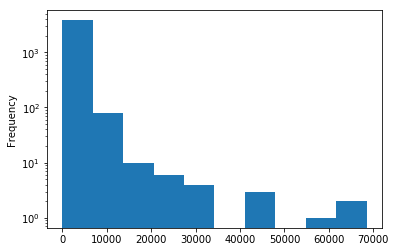

In [56]:
group_df['complexity'].plot(kind='hist', logy=True)

In [57]:
max_val=max(np.log(group_df['complexity']))
data_complexity_df['complexity_percentage'] = np.round(100*np.log(data_complexity_df['complexity'])/max_val,1)

group_df=data_complexity_df.groupby('id_tramite').max()

In [58]:
group_df.sort_values('complexity_percentage', ascending=False).head(30)

,nombre_tramite,requisitos_expand,N_requisitos_parse,LEN_requisitos_str,complexity,complexity_percentage
id_tramite,,,,,,
SINID370-8,Postulación a Fondos Concursables FNDR,rut de la institucion y run del representante ...,48,1427,68496,100.0
4051,Inscripción en Registro de Corredores de Bolsa...,presentacion dirigida a la comision para el me...,38,1691,64258,99.4
SINID370-6,Postulación a Fondos Concursables FNDR,seguridad,46,1238,56948,98.3
715,Inscripción en el Registro de consultores,ultima declaracion de impuestos (formulario 22).,53,877,46481,96.5
NUEVO179,OTORGAMIENTO DE CONCESIÓN MARÍTIMA MAYOR.,n) extracto de la solicitud con las menciones ...,14,3115,43610,95.9
NUEVO175,MODIFICACIÓN SUSTANCIAL DE CONCESIÓN MARÍTIMA ...,m) las solicitudes de organizaciones de pescad...,14,3115,43610,95.9
SINID1562,Postular al Programa de apoyo al patrimonio au...,"modalidad de itinerancias, festivales no compe...",24,1397,33528,93.6
NUEVO178,MODIFICACIÓN SUSTANCIAL DE CONCESIÓN MARÍTIMA ...,si la concesion se solicita a titulo oneroso o...,17,1966,33422,93.6
NUEVO180,OTORGAMIENTO DE CONCESIÓN MARÍTIMA MENOR.,"si el solicitante es persona natural, debera a...",13,2412,31356,93.0


In [59]:
output_file='results/catastro_requisitos_complexity.xlsx'
data_df = data_complexity_df.rename_axis('idx').sort_values(['complexity_percentage','idx'], ascending=[False,True])

writer = pd.ExcelWriter(output_file, engine='xlsxwriter')
data_df.to_excel(writer, sheet_name='Sheet1', index=False)

workbook  = writer.book
worksheet = writer.sheets['Sheet1']

format1 = workbook.add_format({'text_wrap': True})

worksheet.set_column('A:A', 10)
worksheet.set_column('B:C', 50, format1)
worksheet.set_column('D:G', 20)

end_row = len(data_df.index)
end_column = len(data_df.columns)-1
header = [{'header': word} for word in data_df.columns.tolist()]

worksheet.add_table(0, 0, end_row, end_column, {'header_row': True, 'columns': header})
writer.save()

In [60]:
#assert false

# 5. Cargamos en memoria el listado de certificados identificados por la Segpres

In [61]:
segpres_certificados_file='data/Listado certificados - compartido a Metricarts.xlsx'
segpres_certificados_sheetname='Listado CERTIFICADOS'
segpres_certificados_df=pd.read_excel(segpres_certificados_file, sheet_name=segpres_certificados_sheetname)
segpres_certificados_df.head()

,Ministerio,Subsecretaría,Institución,ID trámite,Nombre del trámite,Nivel de Digitalización,URL del trámite,Descripción del trámite,¿Considera Clave única para su realización?,¿El Trámite considera pago?,Precio
0,Ministerio de Salud,Dependencia directa Ministerio,Fondo Nacional de Salud,5241,Certificado de afiliación a FONASA,4.0,https://www.fonasa.cl/sites/fonasa/beneficiari...,Permite obtener certificado de afiliación o no...,No,No,NaN
1,Ministerio de Justicia y Derechos Humanos,Dependencia directa del Ministerio,Servicio de Registro Civil e Identificación,3442,Certificado de antecedentes,4.0,https://registrocivilwp.srcei.cl/tramite/certi...,Permite conocer oficialmente si una persona ti...,Si,Si,1050
2,Ministerio de Educación,Dependencia directa del Ministerio,Subsecretaría de Educación,2272,Certificado anual de estudios,4.0,http://certificados.mineduc.cl,Certificados disponibles en línea para entrega...,No,No,NaN
3,Ministerio de Justicia y Derechos Humanos,Dependencia directa del Ministerio,Servicio de Registro Civil e Identificación,3370,Certificado de anotaciones vigentes de vehícul...,4.0,https://www.registrocivil.cl/OficinaInternet/h...,Permite acceder a datos que identifican el veh...,No,Si,840
4,Ministerio del Trabajo y Previsión Social,Subsecretaría de Previsión Social,Superintendencia de Pensiones,3310,Certificado de afiliación a una AFP,4.0,http://www.spensiones.cl/apps/certificados/ind...,"Permite acreditar, a través de un documento of...",No,No,NaN


In [62]:
segpres_certificados_df['nombre_certificado'] = segpres_certificados_df['Nombre del trámite'].apply(standardize_string)

In [63]:
segpres_certificados_df.sort_values('nombre_certificado', inplace=True)

In [64]:
segpres_certificados_df.head()

,Ministerio,Subsecretaría,Institución,ID trámite,Nombre del trámite,Nivel de Digitalización,URL del trámite,Descripción del trámite,¿Considera Clave única para su realización?,¿El Trámite considera pago?,Precio,nombre_certificado
98,Ministerio de Educación,Dependencia directa del Ministerio,Dirección de Bibliotecas Archivos y Museos,SINID728,Certificado para optar a beneficio de interna...,1.0,http://www.mnba.cl/617/w3-propertyvalue-38965....,Permite obtener un certificado firmado por el ...,No,No,NaN,certificado para optar a beneficio de interna...
2,Ministerio de Educación,Dependencia directa del Ministerio,Subsecretaría de Educación,2272,Certificado anual de estudios,4.0,http://certificados.mineduc.cl,Certificados disponibles en línea para entrega...,No,No,NaN,certificado anual de estudios
94,"Ministerio de Economía, Fomento y Turismo",Dependencia directa del Ministerio,Subsecretaría de Economía,SINID1369,Certificado artículo 8vo Transitorio Cooperativa,4.0,http://plataformadaes.economia.cl/,Extracto que contiene el acta de la Junta Gene...,No,No,NaN,certificado articulo 8vo transitorio cooperativa
100,Ministerio del Trabajo y Previsión Social,Subsecretaría para las Fuerzas Armadas,Caja de Previsión de la Defensa Nacional,SINID1201,Certificado Cuota de Funerales,0.0,NaN,Consiste en la solicitud de un certificado que...,No,No,NaN,certificado cuota de funerales
37,Ministerio del Trabajo y Previsión Social,Subsecretaría de Previsión Social,Instituto de Seguridad Laboral,5118,Certificado de Accidentabilidad,4.0,http://www.isl.gob.cl/solicitud-de-certificado...,Certificado que solicita la entidad empleadora...,No,No,NaN,certificado de accidentabilidad


Determinamos el numero de veces que se repiten los nombres de los certificados

In [65]:
temp_df=segpres_certificados_df.groupby('nombre_certificado').size().reset_index(name='count')
temp_df.sort_values('count', ascending=False).head()

,nombre_certificado,count
27,certificado de asignacion familiar,2
150,certificado de rentas de ips,1
139,certificado de propiedad,1
140,certificado de propiedad afecta a expropiacion,1
141,certificado de reclamo en tramite,1


In [66]:
segpres_certificados_list = segpres_certificados_df['nombre_certificado'].unique()

In [67]:
segpres_certificados_dict = { name : [name] for name in segpres_certificados_list }

In [68]:
j = json.dumps(segpres_certificados_dict, indent=2)
f = open('results/certificados_segpres.json', 'w')
print(j, file=f)
f.close()

In [69]:
#with open("results/certificados_segpres.json") as test:
#    data = test.read()
#    test_dict = json.loads(data)

In [70]:
#test_dict["certificado anual de estudios"]

In [71]:
len(segpres_certificados_list)

218

In [72]:
segpres_certificados_list[:10]

array(['certificado  para optar a beneficio de internacion de obras de arte a territorio nacional articulo 9, no.2 de la ley no. 19.128',
       'certificado anual de estudios',
       'certificado articulo 8vo transitorio cooperativa',
       'certificado cuota de funerales',
       'certificado de accidentabilidad',
       'certificado de acreditacion de la calidad indigena',
       'certificado de acuerdo de union civil para todo tramite',
       'certificado de aeronavegabilidad',
       'certificado de aeronavegabilidad de exportacion',
       'certificado de afiliacion'], dtype=object)

# 6. Análisis del campo requisitos_expand y creación de catastro_tramites - certificados

Abrir terminal e instalar los siguientes paquetes

`pip install fuzzywuzzy`

`pip install python-Levenshtein`

In [73]:
from fuzzywuzzy import fuzz
from fuzzywuzzy import process

import matplotlib.pyplot as plt

In [74]:
# En caso que queramos volver a cargar en memoria el modulo fuzz

#import importlib
#importlib.reload(fuzz)

Filtramos solamente los registros que contienen la palabra certificado

In [75]:
data_expand_certificados_df = data_expand_df[data_expand_df['requisitos_expand'].str.contains("certificado")]

In [76]:
data_expand_certificados_df.head()

,id_tramite,nombre_tramite,requisitos_expand,N_requisitos_parse,LEN_requisitos_str
26,SINID1511,Inscripción en el Registro especial de adminis...,certificado de constitucion legal de la entidad,5,47
27,4105,Inscripción o eliminación del Registro de Agen...,certificado de nacimiento o fotocopia legaliza...,4,211
27,4105,Inscripción o eliminación del Registro de Agen...,"certificado de antecedentes comerciales, emiti...",4,97
27,4105,Inscripción o eliminación del Registro de Agen...,certificado de antecedentes para fines especia...,4,295
27,4105,Inscripción o eliminación del Registro de Agen...,para efectos de la acreditacion del requisito ...,4,629


In [77]:
len(data_expand_certificados_df)

2696

In [78]:
temp_group = data_expand_certificados_df.groupby('id_tramite')
len(temp_group)

966

### Generación de DataFrame usando lista de certificados de Gobierno Digital e identificados por Metric. Los certificados fueron contetanados en un solo string y registro

In [79]:
data_expand_certificados_group = data_expand_certificados_df.groupby('id_tramite')
n_group = len(data_expand_certificados_group)

data_tramites_certificados_list=[]
for i, (name, group) in enumerate(data_expand_certificados_group):
    requisitos_expand_list = list(group['requisitos_expand'])
    
    if i % 50 == 0:
        print("Processing {} of {} - ID tramite: {}".format(i, n_group, name))
    
    certificados_match_segpres = []
    for requisito in requisitos_expand_list:
        #print(requisito)
        fuzz_match = process.extract(requisito, segpres_certificados_list, limit=2, scorer=fuzz.partial_ratio)
        #print(fuzz_match)
        for word in fuzz_match:
            if word[1]>90:
                certificados_match_segpres.append(word[0])
    certificados_match_segpres = list(set(certificados_match_segpres))
    
    #print('requisitos_expand_list: ', requisitos_expand_list)
    certificados_match_metric = []
    for requisito in requisitos_expand_list:
        #re_match = re.search('certificado\S?\s+\w+\s+\w+', requisito)
        re_match = re.findall('certificado.*?(?=certificado|$)', requisito)
        for word in re_match:
            # We match a phrase starting with the word certificado and add a maximum of 8 words
            re_search=re.search('certificado(s)?(?:\W+\w+){,8}', word)
            if re_search:
                temp=re_search.group()
                temp=re.split('\.|,|:|\(|\)', temp)[0]
                temp=temp.strip()
                certificados_match_metric.append(temp)
    #print('certificados_match_metric: ', certificados_match_metric)
    certificados_match_metric = list(set(certificados_match_metric))
    
    certificados_match_segpres_string = "\n".join([word for word in certificados_match_segpres])
    certificados_match_metric_string = "\n".join([word for word in certificados_match_metric])
    
    row = {'id_tramite': name,
            'nombre_tramite': group['nombre_tramite'].values[0],
            'certificados_segpres': certificados_match_segpres_string,
            'certificados_metric': certificados_match_metric_string}

    data_tramites_certificados_list.append(row)    

Processing 0 of 966 - ID tramite: 100
Processing 50 of 966 - ID tramite: 1273
Processing 100 of 966 - ID tramite: 169
Processing 150 of 966 - ID tramite: 21425
Processing 200 of 966 - ID tramite: 25096
Processing 250 of 966 - ID tramite: 2986
Processing 300 of 966 - ID tramite: 34897
Processing 350 of 966 - ID tramite: 3829
Processing 400 of 966 - ID tramite: 43640
Processing 450 of 966 - ID tramite: 5021
Processing 500 of 966 - ID tramite: 5176-05
Processing 550 of 966 - ID tramite: 5436-13
Processing 600 of 966 - ID tramite: 811
Processing 650 of 966 - ID tramite: NUEVO057
Processing 700 of 966 - ID tramite: NUEVO170
Processing 750 of 966 - ID tramite: SINID1278
Processing 800 of 966 - ID tramite: SINID1540
Processing 850 of 966 - ID tramite: SINID357-13
Processing 900 of 966 - ID tramite: SINID829-06
Processing 950 of 966 - ID tramite: SINID951


In [80]:
data_tramites_certificados_df = pd.DataFrame(data_tramites_certificados_list, columns=['id_tramite','nombre_tramite','certificados_segpres','certificados_metric'])
data_tramites_certificados_df.head()

,id_tramite,nombre_tramite,certificados_segpres,certificados_metric
0,100,Desafectación o libre disposición de vehículos...,,certificado de vigencia
1,1003,Autorización para practicar artes marciales,certificado de antecedentes,certificado de antecedentes para fines especiales
2,1009,Autorización para importar implementos de arte...,certificado de antecedentes,certificado de residencia\ncertificado de ante...
3,1012,Autorización para crear una rama de artes marc...,certificado de antecedentes,certificado de antecedentes para fines especia...
4,1021,Autorización para desempeñarse como instructor...,certificado de antecedentes,certificado de residencia\ncertificado para ac...


In [81]:
len(data_tramites_certificados_df)

966

In [82]:
output_file='results/catastro_tramites - certificados_segpres_AND_metric.xlsx'

writer = pd.ExcelWriter(output_file, engine='xlsxwriter')
data_tramites_certificados_df.to_excel(writer, sheet_name='Sheet1', index=False)

workbook  = writer.book
worksheet = writer.sheets['Sheet1']

format1 = workbook.add_format({'text_wrap': True})

worksheet.set_column('A:A', 10)
worksheet.set_column('B:D', 50, format1)

end_row = len(data_tramites_certificados_df.index)
end_column = len(data_tramites_certificados_df.columns)-1
header = [{'header': word} for word in data_tramites_certificados_df.columns.tolist()]

worksheet.add_table(0, 0, end_row, end_column, {'header_row': True, 'columns': header})
writer.save()

### Generación de DataFrame usando lista de certificados identificados por Metric y separados en múltiples registros

In [83]:
data_expand_certificados_group = data_expand_certificados_df.groupby('id_tramite')
n_group = len(data_expand_certificados_group)

data_tramites_certificados_list=[]
for i, (name, group) in enumerate(data_expand_certificados_group):
    requisitos_expand_list = list(group['requisitos_expand'])
    
    if i % 50 == 0:
        print("Processing {} of {} - ID tramite: {}".format(i, n_group, name))
    
    certificados_match_segpres = []
    for requisito in requisitos_expand_list:
        #print(requisito)
        fuzz_match = process.extract(requisito, segpres_certificados_list, limit=2, scorer=fuzz.partial_ratio)
        #print(fuzz_match)
        for word in fuzz_match:
            if word[1]>90:
                certificados_match_segpres.append(word[0])
    certificados_match_segpres = list(set(certificados_match_segpres))
    
    #print('requisitos_expand_list: ', requisitos_expand_list)
    certificados_match_metric = []
    for requisito in requisitos_expand_list:
        #re_match = re.search('certificado\S?\s+\w+\s+\w+', requisito)
        re_match = re.findall('certificado.*?(?=certificado|$)', requisito)
        for word in re_match:
            # We match a phrase starting with the word certificado and add a maximum of 8 words
            re_search=re.search('certificado(s)?(?:\W+\w+){,8}', word)
            if re_search:
                temp=re_search.group()
                temp=re.split('\.|,|:|\(|\)', temp)[0]
                temp=temp.strip()
                certificados_match_metric.append(temp)
    #print('certificados_match_metric: ', certificados_match_metric)
    certificados_match_metric = list(set(certificados_match_metric))
    
    for row in certificados_match_metric:
        row = {'id_tramite': name,
                'nombre_tramite': group['nombre_tramite'].values[0],
                'certificados': row}

        data_tramites_certificados_list.append(row)
    

Processing 0 of 966 - ID tramite: 100
Processing 50 of 966 - ID tramite: 1273
Processing 100 of 966 - ID tramite: 169
Processing 150 of 966 - ID tramite: 21425
Processing 200 of 966 - ID tramite: 25096
Processing 250 of 966 - ID tramite: 2986
Processing 300 of 966 - ID tramite: 34897
Processing 350 of 966 - ID tramite: 3829
Processing 400 of 966 - ID tramite: 43640
Processing 450 of 966 - ID tramite: 5021
Processing 500 of 966 - ID tramite: 5176-05
Processing 550 of 966 - ID tramite: 5436-13
Processing 600 of 966 - ID tramite: 811
Processing 650 of 966 - ID tramite: NUEVO057
Processing 700 of 966 - ID tramite: NUEVO170
Processing 750 of 966 - ID tramite: SINID1278
Processing 800 of 966 - ID tramite: SINID1540
Processing 850 of 966 - ID tramite: SINID357-13
Processing 900 of 966 - ID tramite: SINID829-06
Processing 950 of 966 - ID tramite: SINID951


In [84]:
data_tramites_certificados_df = pd.DataFrame(data_tramites_certificados_list, columns=['id_tramite','nombre_tramite','certificados'])
data_tramites_certificados_df.head()

,id_tramite,nombre_tramite,certificados
0,100,Desafectación o libre disposición de vehículos...,certificado de vigencia
1,1003,Autorización para practicar artes marciales,certificado de antecedentes para fines especiales
2,1009,Autorización para importar implementos de arte...,certificado de residencia
3,1009,Autorización para importar implementos de arte...,certificado de antecedentes para fines especiales
4,1012,Autorización para crear una rama de artes marc...,certificado de antecedentes para fines especia...


In [85]:
len(data_tramites_certificados_df)

2639

In [86]:
output_file='results/catastro_tramites - certificados_separados.xlsx'

writer = pd.ExcelWriter(output_file, engine='xlsxwriter')
data_tramites_certificados_df.to_excel(writer, sheet_name='Sheet1', index=False)

workbook  = writer.book
worksheet = writer.sheets['Sheet1']

format1 = workbook.add_format({'text_wrap': True})

worksheet.set_column('A:A', 10)
worksheet.set_column('B:D', 50, format1)

end_row = len(data_tramites_certificados_df.index)
end_column = len(data_tramites_certificados_df.columns)-1
header = [{'header': word} for word in data_tramites_certificados_df.columns.tolist()]

worksheet.add_table(0, 0, end_row, end_column, {'header_row': True, 'columns': header})
writer.save()